# CNN Based Image Classification for MNIST

## Utils
The below cell contains the code for all the utility functions

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import csv

import sys
import numpy as np
import base64
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow

def getDataLoaders():
    """ Function to get MNIST data

        Returns:
            trainloader: Dataloader for train dataset
            testloader: Dataloader for test dataset
    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])

    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False)
    print()
    return trainloader, testloader


def vizImages(trainloader):

    """ Function to visualize sample training images
        Arguments:
            trainloader: Dataloader for train dataset
 
        TO-DO:
        1. Use plt.subplots() and show an image in each subplot
        2. Make sure there is at least 1 image from each class
    """
    fig=plt.figure()
    i=0
    for (images, labels) in trainloader:
        for k in range(len(labels)):
            
            if (labels[k]==i):
                img=(np.array(images[k])).reshape((28,28))
                plt.subplot(1,10,i+1)
                plt.axis("off")
                plt.imshow(img, cmap='gray')
                i=i+1
            if(i==10):
                plt.show()
    pass

def getClassAcc(testloader, net, batch_size=1):

    """ Compute accuracy for each class

        Arguments:
            testloader: Dataloader for test dataset
            net: instance of the CNN class

         TO-DO:
         1. Enumerate over testloader
         2. Compute number of correct predictions for each class
         3. At the end, print the accuracy of each class
    """
    
    net.eval()
    with torch.no_grad():
        class_correct=list(0 for i in range(10))
        total=list(0 for i in range(10))
        for iter, (images, labels) in enumerate(testloader):
            _,_,outputs = net(images)
            predicted = torch.max(outputs.data, 1)[1].data.numpy().squeeze()
            y=labels.numpy().squeeze()
            for i in range(len(predicted)):
                total[y[i]]+=1
                if predicted[i]==y[i] :   
                    class_correct[predicted[i]]+=1
        for i in range(10):
            print('Accuracy of {}: {:.4f} %'.format(i, 100*class_correct[i]/total[i]))
    pass

def plotLossAcc(train_losses, test_losses, test_accuracies):

    """ Plot train and test results

        Arguments:
            train_losses: Train loss corresponding to each iteration
            test_losses: Test loss corresponding to each epoch
            test_accuracies: Test accuracy corresponding to each epoch

        TO-DO:
        1. Plot train loss v/s epoch
        2. Plot test accuracy v/s epoch
        3. Plot test loss v/s epoch
    """
    e=list(range(1, 11))
    plt.figure(1)
    plt.plot(e,train_losses)
    plt.ylabel('Training loss')
    plt.xlabel('Epoch')
    plt.figure(2)
    plt.plot(e,test_losses)
    plt.ylabel('Test loss')
    plt.xlabel('Epoch')
    plt.figure(3)
    plt.plot(e, test_accuracies)
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.show()
  
def vizConvWeights(net):

    """ Visualize weights of the convolution layers

        Arguments:
            net: instance of the CNN class
 
        TO-DO:
        1. Get the weights of conv1 layer. You'll have 10 kernels, each of dimension 5x5
        2. Create a subplot and visualize each kernel in a subplot
    """
    plt.figure(1)
    print('The weights of convolution layer 1 are visualized as:')
    fig,axs=plt.subplots(2,5, figsize=(10,5))
    plt.tight_layout()
    xiw=net.c1.weight.data.numpy().squeeze()
    for i in range(10):
        axs[i//5,i%5].imshow(xiw[i])
    plt.show()   
    plt.figure(2)
    print('The weights of convolution layer 2 ,one from each of the 20 filter layers are visualized as:)')
    fig,axs=plt.subplots(4,5, figsize=(10,10))
    plt.tight_layout()
    xbw=net.c2.weight.data.numpy().squeeze()
    
    for i in range(20):
        axs[i//5,i%5].imshow(xbw[i][1])
    plt.show()
    
def vizFeatureMaps(testloader, net):

    """ Visualize weights of the convolution layers

        Arguments:
            testloader: Dataloader for test dataset
            net: instance of the CNN class

        TO-DO:
        1. Pass one image through the network and get its conv1 and conv2 features
        2. conv1: Get the features after conv1. There'll be 10 24x24 feature maps. Create a subplot and visualize them
        3. conv2: Get the features after conv2. There'll be 20 8x8 feature maps. Create a subplot and visualize them
    """
    with torch.no_grad():
        for iter, (images, labels) in enumerate(testloader):
            f1, f2, output=net.forward(images)
            break
    plt.figure(figsize=(10,5))
    plt.tight_layout()
    print('The feature maps after conv 1 are visualized as:')
    for i in range(10):
    
        plt.subplot(2,5,i+1)
        plt.imshow(f1[0,i,:,:])
        plt.axis("off")
        plt.title("%d"%(i+1))
    plt.show()
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    print('The feature maps after conv 2 are visualized as:')
    for i in range(20):
    
        plt.subplot(4,5,i+1)
        plt.imshow(f2[0,i,:,:])
        plt.axis("off")
        plt.title("%d"%(i+1))
    plt.show()
    pass
# end
# from now on you can use img as an image, but make sure you know what you are doing!
    
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

## Models
The below cell contains classes for defining the network architecture

In [2]:
import torch.nn as nn
import torch.nn.functional as F
#import ipdb

"""Class to define the CNN architecture"""

class Net1(nn.Module):
    def __init__(self):
        """ Function to specify and initialize all the layers

        TO-DO:
        1. Initialize each of the layer
        """
        super(Net1, self).__init__()
        self.c1 = nn.Conv2d(1, 10, kernel_size=(5,5), stride=(1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.relu = nn.ReLU()
        
        self.c2 = nn.Conv2d(10, 20, kernel_size=(5,5), stride=(1,1))
        self.dropout =  nn.Dropout2d(p=0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.fc1 = nn.Linear(in_features=320, out_features=50, bias=True)
        self.fc2 = nn.Linear(in_features=50, out_features=10, bias=True)
        pass
            
    def forward(self, x):

        """ Function to do forward prop
        Arguments:
            x: Input data of shape batch_size x num_channels x height x width
        Returns:
            out: final output of the network. Shape:batch_size x num_classes(10)
            f1: output from first convolution layer. Shape: batch_size x 10 x 24 x 24
            f2: output from first convolution layer. Shape: batch_size x 20 x 8 x 8

        TO-DO:
        1. Do forward prop as specified in the handout
        2. Return final output, conv1 features, conv2 features
        """
        f1 = self.c1(x)
        out=self.pool1(f1)
        out=self.relu(out)
        
        f2 = self.c2(out)
        out=self.dropout(f2)
        out=self.pool2(out)
        out=self.relu(out)
        out = out.reshape(out.size(0), -1)
        out=self.fc1(out)
        out=self.dropout(self.relu(out))
        out = out.reshape(out.size(0), -1)
        out = self.fc2(out)
        
        return f1, f2, out

## Main
The below cell contains the code for training the model, testing on heldout dataset and visualizing the results for interpretability

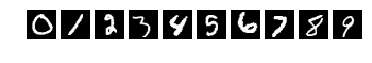

Epoch is 1, accuracy is 96.82, Loss is: 0.0992
Epoch is 2, accuracy is 97.83, Loss is: 0.0717
Epoch is 3, accuracy is 98.14, Loss is: 0.0611
Epoch is 4, accuracy is 98.18, Loss is: 0.0571
Epoch is 5, accuracy is 98.39, Loss is: 0.0514
Epoch is 6, accuracy is 98.36, Loss is: 0.0496
Epoch is 7, accuracy is 98.66, Loss is: 0.0443
Epoch is 8, accuracy is 98.63, Loss is: 0.0431
Epoch is 9, accuracy is 98.56, Loss is: 0.0436
Epoch is 10, accuracy is 98.63, Loss is: 0.0413


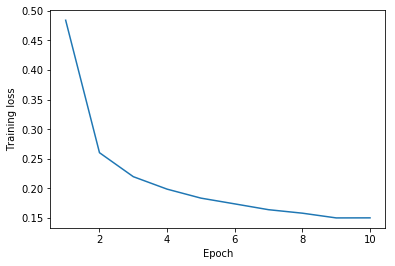

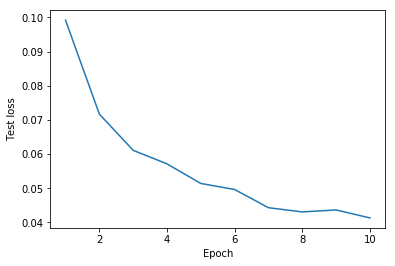

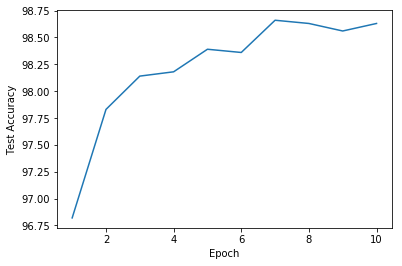

The feature maps after conv 1 are visualized as:


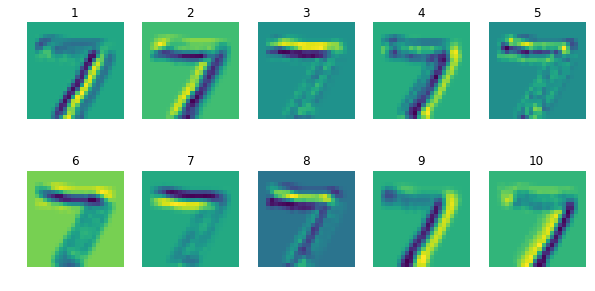

The feature maps after conv 2 are visualized as:


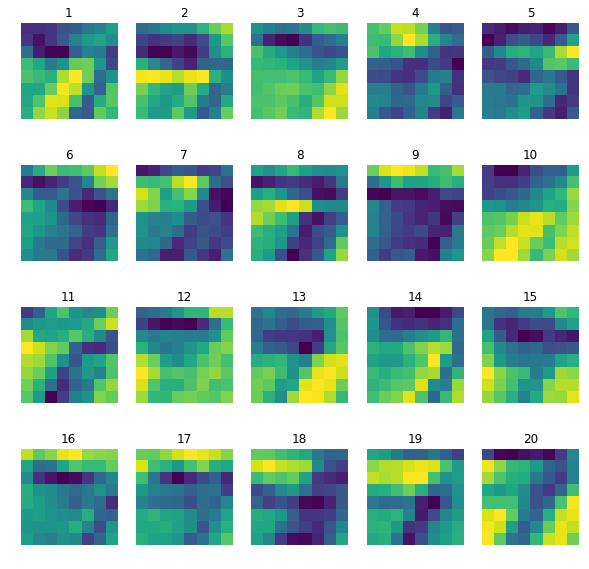

The weights of convolution layer 1 are visualized as:


<Figure size 432x288 with 0 Axes>

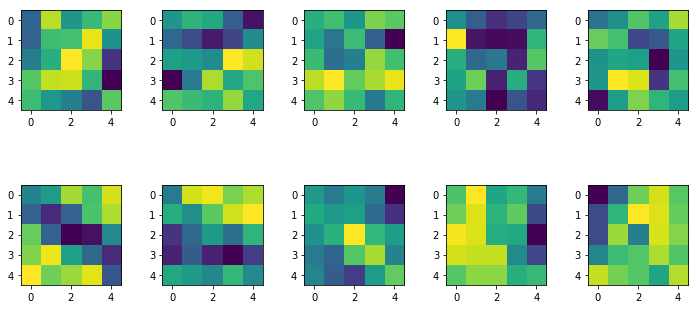

The weights of convolution layer 2 ,one from each of the 20 filter layers are visualized as:)


<Figure size 432x288 with 0 Axes>

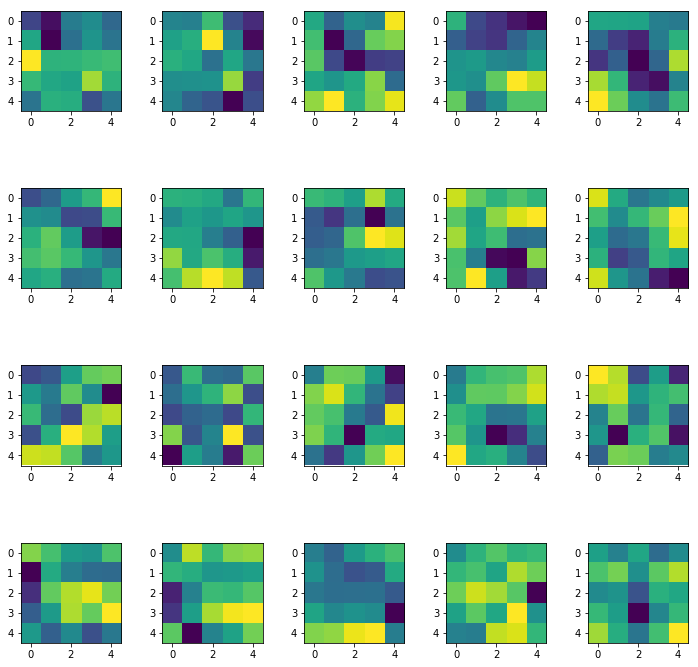

Accuracy of 0: 99.5918 %
Accuracy of 1: 99.4714 %
Accuracy of 2: 99.3217 %
Accuracy of 3: 99.1089 %
Accuracy of 4: 98.8798 %
Accuracy of 5: 98.6547 %
Accuracy of 6: 98.7474 %
Accuracy of 7: 97.7626 %
Accuracy of 8: 97.8439 %
Accuracy of 9: 96.8285 %


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

def train(trainloader, optimizer, criterion, epoch, net):
    """ Function to train the model
        Arguments:
            trainloader: Dataloader for train dataset
            optimizer: Optimizer for training
            criterion : loss function
            epoch: epoch number
            net: Network instance

        Returns:
            train_loss (list): training loss after 1 pass over the entire training data

     TO-DO:
     1. Enumerate over the trainloader
     2. Do forward prop and backprop
     3. Store the loss after each iteration
     4. Return mean training loss for the epoch
     """
    total_step = len(trainloader)
    loss_list = []
    net.train()
    #for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Run the forward pass
        
        _,_,outputs = net(images)
        loss = criterion(outputs, labels)
        

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #if (i + 1) % 100 == 0:
        #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  #.format(epoch + 1, num_epochs, i + 1, total_step, loss.item())
        k=loss.item()
        loss_list.append(k)
    loss_list=np.asarray(loss_list)
    mean_loss=loss_list.mean()
    return mean_loss
    
 

def test(testloader, criterion, net):
    """ Function to test the model
        Arguments:
            testloader: Dataloader for test dataset
            criterion : loss function
            net: Network instance

        Returns:
            loss: mean test loss after 1 pass over the entire test data
            acc: mean test accuracy after 1 pass over the entire test data

     TO-DO:
     1. Enumerate over the testloader
     2. Do forward prop 
     3. Compute loss and accuracy
     4. Return the mean loss and accuracy after 1 pass over the entire data
     """

    net.eval()
    loss_list=[]
    with torch.no_grad():
        true = 0
        total_num = 0
        for images, labels in testloader:
            #images = images.reshape(-1, 28*28)
            _,_,outputs = net(images)
            loss = criterion(outputs, labels)
            k=loss.item()
            loss_list.append(k)
    
            _, predicted = torch.max(outputs.data, 1)
            total_num= total_num+labels.size(0)
            true =true+ (predicted == labels).sum().item()
    accuracy=(100 * true / total_num)
    loss_list=np.asarray(loss_list)
    mean_loss=loss_list.mean()
    return accuracy, mean_loss
    
    


def main():

    """
    Function to run the entire pipeline.

    TO-DO:
    1. Call utils.vizImages() to visualize sample training images
    2. Define the network, optimizer and criterion
    3. Train for 10 epochs
    4. Compute test loss and accuracy after each epoch
    5. Once trained, call plotLossAcc() to plot the train loss, test loss and test accuracy
    6. Call vizFeatureMaps() to visualize the feature maps
    7. Call vizConvWeights() to visualize the conv1 and conv2 kernel weights
    8. Print classwise accuracy
    9. (Optional) Save the model intermittently and load from a checkpoint
    """
    
    resume_checkpoint = 0
    start_epoch = 0
    max_epoch = 10
    visualize_results = 1
    trainloader, testloader = getDataLoaders()
    vizImages(trainloader)
    net = Net1()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    train_loss=[]
    accuracy=[]
    test_loss=[]
    for epoch in range(max_epoch):
        tr_loss=train(trainloader, optimizer, criterion, epoch, net)
        
        acc, te_loss=test(testloader, criterion, net)
        print('Epoch is {}, accuracy is {}, Loss is: {:.4f}'.format(epoch+1, acc, te_loss))
        train_loss.append(tr_loss)
        accuracy.append(acc)
        test_loss.append(te_loss)
    plotLossAcc(train_loss,  test_loss, accuracy)
    vizFeatureMaps(testloader, net)
    vizConvWeights(net)
    getClassAcc(testloader, net, batch_size=1)
    
if __name__=='__main__':

    main()

Convolution layers have filters which act as feature detectors from the original imagee. Different values of the filter matrix will produce different featiure maps as the dot product is different. Different filters may be useful for edge detection, curve detection, sharpen, blur. 
Consider the feature maps from convolution of the mnist dataset. Convolution layer 1 is is learning edge detection or contour. For convolution layer 2,  Darker blocks correspond to higher weights of corresponding pixels whereas lighter blocks have low weightage. Clear regions of light and dark indicate that it is learning things relating to spatial structure in convolution layer 2.

The hardest digits to classify are 6 and 9. Because they have curves and loops and cannot be determined. They can easily be confused with other images. It is hard to classify type of trees and breeds of dogs from images. A dog can be detected but not its breed. It also fails with regards to tiny parts of nature:an ant on a leaf or a tiny caterpillar.

Overfitting occurs when the training set accuracy is higher than the test set accuracy. If convergence has been attained but accuracy and loss don't level out, overfitting may occur. The model recognizes specific images in the training set instead of general patterns.To avoid overfitting: add regularization i.e. dropouts to set activation functions to 0 at random or even l1,l2. Add more data or reduce architectural complexity if possible. Data augmentation like zooming in or adding a color filter.